In [1]:
import pandas as pd
import random
import os
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed = 42

random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True

In [3]:
## data_colection

df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
df = df.drop(columns=['id'])

test_df = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')

df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


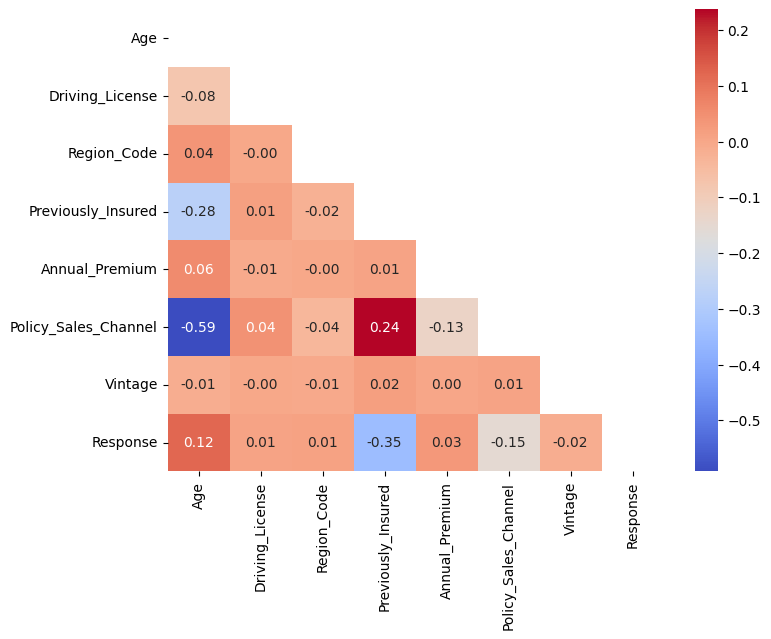

In [4]:
cor_mat = df.corr(method="pearson",numeric_only=True)
mask = np.triu(np.ones_like(cor_mat))

plt.figure(figsize=(8, 6))
sns.heatmap(cor_mat, cmap='coolwarm', fmt='.2f', annot=True, mask=mask)
plt.show()

In [5]:
## feats_engin

nums = [ # рофлсон
]
cats = [c for c in df.columns if c not in nums+['id', 'Response']]

In [6]:
df.nunique()

Gender                      2
Age                        66
Driving_License             2
Region_Code                54
Previously_Insured          2
Vehicle_Age                 3
Vehicle_Damage              2
Annual_Premium          51728
Policy_Sales_Channel      152
Vintage                   290
Response                    2
dtype: int64

In [7]:
for feature in nums:
    X = df[[feature]].values  # Подготовим данные для одного признака
    inertias = []  
    
    # Пробуем разное количество кластеров от 1 до 10
    for k in tqdm(range(1, 6)):
        kmeans =  KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        
    ratios = []
    for i in range(1, len(inertias) - 1):
        ratio = (inertias[i-1] - inertias[i]) / (inertias[i] - inertias[i+1])
        ratios.append(ratio)
    
    optimal_clusters = np.argmax(ratios) + 2
    print(f'оптимальным будет {optimal_clusters}')
    
    # Построение графика «правила локтя» для текущего признака
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 6), inertias, marker='o')
    plt.title(f'Elbow Method for {feature}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

In [8]:
best_n_clusters = [2, 3, 2]

In [9]:
for n, feature in tqdm(enumerate(nums), total = len(nums)):
    X = df[[feature]].values 
    X_test = test_df[[feature]].values 
    
    kmeans =  KMeans(n_clusters=best_n_clusters[n], random_state=42)
    predict_train = kmeans.fit_predict(X)
    predict_test = kmeans.predict(X_test)
    
    df[f'{feature}_KMeans'] = predict_train
    test_df[f'{feature}_KMeans'] = predict_test
    
    df[f'{feature}_KMeans'] = df[f'{feature}_KMeans'].astype(int) 
    test_df[f'{feature}_KMeans'] = test_df[f'{feature}_KMeans'].astype(int) 
    
    cats.append(f'{feature}_KMeans')

0it [00:00, ?it/s]

In [10]:
nums_post_process = []
for c in tqdm(nums, total = len(nums)):
    df[f"{c}_square"] = df[c]**2
    df[f"{c}_sqrt"] = df[c]**(0.5)
    df[f"{c}_log"] = np.log(df[c] + 1)
    
    test_df[f"{c}_square"] = test_df[c]**2
    test_df[f"{c}_sqrt"] = test_df[c]**(0.5)
    test_df[f"{c}_log"] = np.log(test_df[c] + 1)
    
    nums_post_process.append(f"{c}_square")
    nums_post_process.append(f"{c}_sqrt")
    nums_post_process.append(f"{c}_log")

    
nums = nums + nums_post_process

0it [00:00, ?it/s]

In [11]:
## feats_transform

# for c in tqdm(cats):
#     df[c] = f'{c}_'+df[c].astype(str)

# uni = set()|
# for c in tqdm(cats):
#     uni = uni | set(df[c])

# tokens = dict(zip(uni, 
#                   range(len(uni))))
# for i,k in enumerate(tokens):
#     print (k, tokens[k])
#     if i == 5:
#         break


# for column in tqdm(cats, total = len(cats)):
#     encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
#     df[column] = encoder.fit_transform(df[[column]])
#     test_df[column] = encoder.transform(test_df[[column]])
#     df[column] = df[column].astype('int')
#     test_df[column] = test_df[column].astype('int')


# for column in cats:
#     df[column] = df[column].astype('str')
#     test_df[column] = test_df[column].astype('str')


gender_mapping = {'Male': 0, 'Female': 1}
vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
vehicle_damage_mapping = {'No': 0, 'Yes': 1}
        
df['Gender'] = df['Gender'].map(gender_mapping)
test_df['Gender'] = test_df['Gender'].map(gender_mapping)
df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age_mapping)
test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map(vehicle_age_mapping)
df['Vehicle_Damage'] = df['Vehicle_Damage'].map(vehicle_damage_mapping)
test_df['Vehicle_Damage'] = test_df['Vehicle_Damage'].map(vehicle_damage_mapping)

for column in cats:
    df[column] = df[column].astype(int)
    test_df[column] = test_df[column].astype(int)

In [12]:
pd.set_option('display.max_columns', None)
df.head(5)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,21,1,35,0,1,1,65101,124,187,0
1,0,43,1,28,0,2,1,58911,26,288,1
2,1,25,1,14,1,0,0,38043,152,254,0
3,1,35,1,1,0,1,1,2630,156,76,0
4,1,36,1,15,1,1,0,31951,152,294,0


In [13]:
## feats_treat

In [14]:
## feats_select

In [15]:
## data_split

DEBUG = False

if DEBUG:
    df = df.iloc[:100*1000]

# **Just Catboost**

In [16]:
## data_split

train_df, val_df = train_test_split(df, test_size=.20, random_state=2)

train_df.reset_index(drop=True, 
               inplace=True)
val_df.reset_index(drop=True, 
                 inplace=True)

y = train_df['Response']
X = train_df.drop(columns = 'Response')
y_val = val_df['Response']
X_val = val_df.drop(columns = 'Response')

In [17]:
# model = CatBoostClassifier(
#     #scale_pos_weight=scale_pos_weight_value,
#     #auto_class_weights='SqrtBalanced',
#     #auto_class_weights='Balanced',
#     loss_function='Logloss',
#     eval_metric='AUC',
#     random_seed=42,
#     logging_level='Silent',
#     iterations=1000,
#     task_type="GPU",
#     devices='0',
#     use_best_model=True,
#     early_stopping_rounds=100
# )

model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    learning_rate=0.05,
    iterations=1000,
    depth=9,
    l2_leaf_reg=0.5,
    task_type='GPU',
    devices='0',
    random_seed=42,
    logging_level='Silent',  
)

model.fit(
    X, y,
    cat_features=cats,
    eval_set=[(X_val, y_val)],
    logging_level='Verbose', #Verbose
)
    
print(" AUC по test: ", model.get_best_score()['validation']['AUC'])

predict = model.predict_proba(test_df.drop(columns=['id']))[:,1:].flatten()
submission = pd.DataFrame({'id' : test_df.id, 'target' : predict})
submission.to_csv('Catboost_submission.csv', index=False)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8739658	best: 0.8739658 (0)	total: 9.7s	remaining: 2h 41m 28s
1:	total: 10.7s	remaining: 1h 29m 3s
2:	total: 11.9s	remaining: 1h 5m 41s
3:	total: 12.9s	remaining: 53m 37s
4:	total: 13.9s	remaining: 46m 7s
5:	test: 0.8799923	best: 0.8799923 (5)	total: 15.1s	remaining: 41m 40s
6:	total: 16.3s	remaining: 38m 33s
7:	total: 17.6s	remaining: 36m 26s
8:	total: 18.7s	remaining: 34m 14s
9:	total: 19.9s	remaining: 32m 48s
10:	test: 0.8826391	best: 0.8826391 (10)	total: 21s	remaining: 31m 30s
11:	total: 22.4s	remaining: 30m 41s
12:	total: 23.3s	remaining: 29m 25s
13:	total: 24.3s	remaining: 28m 33s
14:	total: 25.3s	remaining: 27m 39s
15:	test: 0.8840283	best: 0.8840283 (15)	total: 26.2s	remaining: 26m 50s
16:	total: 27.3s	remaining: 26m 16s
17:	total: 28.3s	remaining: 25m 43s
18:	total: 29.4s	remaining: 25m 18s
19:	total: 30.7s	remaining: 25m 1s
20:	test: 0.8848224	best: 0.8848224 (20)	total: 32s	remaining: 24m 52s
21:	total: 33.5s	remaining: 24m 48s
22:	total: 34.5s	remaining: 24m 25s

# **Catboost KFold**

In [18]:
## data_split
y = df['Response']
X = df.drop(columns = 'Response')

In [19]:
## model_trainer

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

catboost_cross_val_predictions = []
for _, (train_index, test_index) in tqdm(enumerate(skf.split(X, y)), total = 5):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = CatBoostClassifier(
        #scale_pos_weight=scale_pos_weight_value,
        auto_class_weights='SqrtBalanced',
        #auto_class_weights='Balanced',
        loss_function='Logloss',
        eval_metric='AUC',
        learning_rate=0.05,
        random_seed=42,
        logging_level='Silent',
        iterations=5000,
        task_type="GPU",
        depth=9,
        devices='0',
        use_best_model=True,
        early_stopping_rounds=100
    )

    model.fit(
        X_train, y_train,
        cat_features=cats,
        eval_set=[(X_test, y_test)],
        logging_level='Silent', #Verbose
    )
    
    print(" AUC по test: ", model.get_best_score()['validation']['AUC'])

    predict = model.predict_proba(test_df.drop(columns=['id']))[:,1:].flatten()
    catboost_cross_val_predictions.append(predict)

  0%|          | 0/5 [00:00<?, ?it/s]

Default metric period is 5 because AUC is/are not implemented for GPU


 AUC по test:  0.8949770331382751


Default metric period is 5 because AUC is/are not implemented for GPU


 AUC по test:  0.8945112228393555


Default metric period is 5 because AUC is/are not implemented for GPU


 AUC по test:  0.8948261141777039


Default metric period is 5 because AUC is/are not implemented for GPU


 AUC по test:  0.8946568965911865


Default metric period is 5 because AUC is/are not implemented for GPU


 AUC по test:  0.8953609466552734


In [20]:
first_iter = True
for predict in catboost_cross_val_predictions:
    if first_iter != True:
        result_proba = result_proba + predict
    else:
        result_proba = predict

result_proba = result_proba/5

submission = pd.DataFrame({'id' : test_df.id, 'target' : result_proba})
submission.to_csv('Catboost_submission_crossval.csv', index=False)

# **Catboost Kfold + Meta Catboost**

In [21]:
## data_split

train_df, val_df = train_test_split(df, test_size=.20, random_state=42)

train_df.reset_index(drop=True, 
               inplace=True)
val_df.reset_index(drop=True, 
                 inplace=True)

y = train_df['Response']
X = train_df.drop(columns = 'Response')
y_val = val_df['Response']
X_val = val_df.drop(columns = 'Response')

In [22]:
# ## model_trainer

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

catboost_cross_val_predict = []
catboost_cross_test_predict = []
for _, (train_index, test_index) in tqdm(enumerate(skf.split(X, y)), total = 5):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = CatBoostClassifier(
        #scale_pos_weight=scale_pos_weight_value,
        auto_class_weights='SqrtBalanced',
        #auto_class_weights='Balanced',
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        depth=9,
        l2_leaf_reg=0.5,
        logging_level='Silent',
        iterations=1000,
        task_type="GPU",
        devices='0',
        learning_rate=0.05,
        use_best_model=True,
        early_stopping_rounds=100
    )

    model.fit(
        X_train, y_train,
        cat_features=cats,
        eval_set=[(X_test, y_test)],
        logging_level='Silent', #Verbose
    )
    
    y_pred_proba = model.predict_proba(X_val)[:, 1:]
    
#     auc_score = roc_auc_score(y_val.values, y_pred_proba)
#     print("AUC по val: ", auc_score)
    
    print("AUC по test: ",model.get_best_score()['validation']['AUC'])

    predict = model.predict_proba(test_df.drop(columns=['id']))[:,1:].flatten()
    
    catboost_cross_val_predict.append(y_pred_proba.flatten())
    catboost_cross_test_predict.append(predict)

  0%|          | 0/5 [00:00<?, ?it/s]

Default metric period is 5 because AUC is/are not implemented for GPU


AUC по test:  0.8943939805030823


Default metric period is 5 because AUC is/are not implemented for GPU


AUC по test:  0.8937061429023743


Default metric period is 5 because AUC is/are not implemented for GPU


AUC по test:  0.8938923478126526


Default metric period is 5 because AUC is/are not implemented for GPU


AUC по test:  0.8939045071601868


Default metric period is 5 because AUC is/are not implemented for GPU


AUC по test:  0.8939201831817627


In [23]:
for n, proba in enumerate(catboost_cross_val_predict):
    X_val[f'model_{n}_redict'] = proba
    
for n, proba in enumerate(catboost_cross_test_predict):
    test_df[f'model_{n}_redict'] = proba    

In [24]:
X_val, X_val_, y_val, y_val_ = train_test_split(X_val, y_val, test_size=.20, random_state=42, stratify=y_val)

X_val.reset_index(drop=True, 
               inplace=True)
X_val_.reset_index(drop=True, 
                 inplace=True)
y_val.reset_index(drop=True, 
               inplace=True)
y_val_.reset_index(drop=True, 
                 inplace=True)

In [25]:
model = CatBoostClassifier(
    auto_class_weights='SqrtBalanced',
    loss_function='Logloss',
    eval_metric='AUC',
    learning_rate=0.01,
    iterations=1000,
    depth=6,
    task_type='GPU',
    devices='0',
    random_seed=42,
    logging_level='Silent',  
)


model.fit(
    X_val, y_val,
    cat_features=cats,
    eval_set=[(X_val_, y_val_)],
    logging_level='Verbose', #Verbose
)
    
print(" AUC по test: ", model.get_best_score()['validation']['AUC'])

predict = model.predict_proba(test_df.drop(columns=['id']))[:,1:].flatten()
submission = pd.DataFrame({'id' : test_df.id, 'target' : predict})
submission.to_csv('Catboost_submission_METACatboost.csv', index=False)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8881206	best: 0.8881206 (0)	total: 2.05s	remaining: 34m 4s
1:	total: 2.17s	remaining: 18m 2s
2:	total: 2.29s	remaining: 12m 39s
3:	total: 2.4s	remaining: 9m 58s
4:	total: 2.52s	remaining: 8m 21s
5:	test: 0.8933277	best: 0.8933277 (5)	total: 2.64s	remaining: 7m 17s
6:	total: 2.75s	remaining: 6m 30s
7:	total: 2.87s	remaining: 5m 55s
8:	total: 2.98s	remaining: 5m 28s
9:	total: 3.1s	remaining: 5m 6s
10:	test: 0.8941818	best: 0.8941818 (10)	total: 3.21s	remaining: 4m 48s
11:	total: 3.33s	remaining: 4m 34s
12:	total: 3.44s	remaining: 4m 21s
13:	total: 3.56s	remaining: 4m 10s
14:	total: 3.67s	remaining: 4m 1s
15:	test: 0.8947422	best: 0.8947422 (15)	total: 3.79s	remaining: 3m 52s
16:	total: 3.9s	remaining: 3m 45s
17:	total: 4.03s	remaining: 3m 39s
18:	total: 4.14s	remaining: 3m 34s
19:	total: 4.26s	remaining: 3m 28s
20:	test: 0.8948528	best: 0.8948528 (20)	total: 4.38s	remaining: 3m 23s
21:	total: 4.49s	remaining: 3m 19s
22:	total: 4.62s	remaining: 3m 16s
23:	total: 4.74s	remaining